## Pre-processing and Modeling

### without pri and sec school (v3 has it)

#### Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

#### Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures 

import statsmodels.api as sm
import math


In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [3]:
housing = pd.read_csv('./housing3.csv', low_memory=False)
housing.head()

,Unnamed: 0,id,flat_type,flat_model,resale_price,Tranc_Year,floor_area_sqft,commercial,planning_area,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_name,sec_sch_nearest_dist,sec_sch_name,resale_price_log,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale
0,0,88471,4 ROOM,Model A,680000.0,2016,6.876017,N,Kallang,6.997679,1.945910,5.041833,2.564949,4.430817,4.094345,5.799344,3.381926,7.037584,Geylang Methodist School,7.037584,Geylang Methodist School,13.429848,1.261663,0.0,4.955827,2.397895,2.302585
1,1,122598,5 ROOM,Improved,665000.0,2012,7.243742,N,Bishan,6.764971,1.098612,6.461706,1.945910,4.382027,4.343805,6.806453,4.064019,6.029741,Kuo Chuan Presbyterian Primary School,6.104557,Kuo Chuan Presbyterian Secondary School,13.407542,0.851318,0.0,4.718499,2.079442,3.218876
2,2,170897,EXECUTIVE,Apartment,838000.0,2013,7.346021,N,Bukit Batok,7.285904,1.386294,7.474252,0.000000,4.430817,4.553877,7.196126,5.369465,6.212304,Keming Primary School,5.193371,Yusof Ishak Secondary School,13.638773,2.227732,0.0,4.499810,2.639057,2.772589
3,3,86070,4 ROOM,Model A,550000.0,2012,7.010936,Y,Bishan,6.856646,1.386294,6.587846,2.197225,3.465736,4.454347,6.810642,3.770379,5.964904,Catholic High School,5.964904,Catholic High School,13.217674,0.799040,0.0,4.317488,1.098612,2.995732
4,4,153632,4 ROOM,Simplified,298000.0,2017,6.795048,N,Yishun,6.592732,0.693147,7.339636,0.000000,3.806662,0.000000,6.021856,4.863084,5.994462,Naval Base Primary School,5.743085,Orchid Park Secondary School,12.604849,1.328843,0.0,3.871201,0.693147,3.401197


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149805 entries, 0 to 149804
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 149805 non-null  int64  
 1   id                         149805 non-null  int64  
 2   flat_type                  149805 non-null  object 
 3   flat_model                 149805 non-null  object 
 4   resale_price               149805 non-null  float64
 5   Tranc_Year                 149805 non-null  int64  
 6   floor_area_sqft            149805 non-null  float64
 7   commercial                 149805 non-null  object 
 8   planning_area              149805 non-null  object 
 9   Mall_Nearest_Distance      149805 non-null  float64
 10  Mall_Within_2km            149805 non-null  float64
 11  Hawker_Nearest_Distance    149805 non-null  float64
 12  Hawker_Within_2km          149805 non-null  float64
 13  hawker_food_stalls         14

In [6]:
# Converting the following variables to categorical 

housing['Tranc_Year'] = housing['Tranc_Year'].astype('object')
housing['id'] = housing['id'].astype('object')
id_no = housing['id'].astype('object')

In [7]:
# Identifying categorical predictors for one-hot encoding

numerical_var = housing.select_dtypes(include=['number'])
numerical_var.columns

Index(['Unnamed: 0', 'resale_price', 'floor_area_sqft',
       'Mall_Nearest_Distance', 'Mall_Within_2km', 'Hawker_Nearest_Distance',
       'Hawker_Within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'sec_sch_nearest_dist', 'resale_price_log',
       'distance_from_CBD', '1_2_3_rooms_sold', '4_5_other_rooms_sold',
       'est_floor_level', 'age_at_sale'],
      dtype='object')

In [8]:
numerical_var.drop(columns = ['resale_price','resale_price_log'], inplace = True)

In [9]:
# Standardising predictors

ss = StandardScaler()
num_ss = ss.fit_transform(numerical_var)
num_ss = pd.DataFrame(num_ss, columns = numerical_var.columns)

### Pre-Processing

In [10]:
# Identifying categorical predictors for one-hot encoding

categorical_var = housing.select_dtypes(include=['object'])
categorical_var.drop(columns = 'id', inplace = True)

In [11]:
# Dummifying all categorical variables

categorical_var = pd.get_dummies(columns=categorical_var.columns,data=housing, drop_first=True)

/var/folders/r9/9246nqp9249ghjl6r9xy_dwr0000gn/T/ipykernel_7451/1831883889.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical_var = pd.get_dummies(columns=categorical_var.columns,data=housing, drop_first=True)


In [12]:
housing = pd.concat([num_ss, categorical_var], axis=1)

In [13]:
housing.head()

,Unnamed: 0,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,Unnamed: 0,id,resale_price,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,resale_price_log,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,-1.731869,-0.170481,1.090917,0.865394,-1.628543,1.742712,1.287963,0.609850,-1.127165,-2.378396,2.123932,1.654816,-0.846661,-0.746648,0.756021,0.723457,-1.057360,0,88471,680000.0,6.876017,6.997679,1.945910,5.041833,2.564949,4.430817,4.094345,5.799344,3.381926,7.037584,7.037584,13.429848,1.261663,0.0,4.955827,2.397895,2.302585,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.731846,1.241433,0.707922,-0.846873,-0.175451,1.077630,1.188499,0.723891,0.550484,-1.070697,0.366398,0.071897,-1.440882,-0.746648,0.570380,0.273955,0.313746,1,122598,665000.0,7.243742,6.764971,1.098612,6.461706,1.945910,4.382027,4.343805,6.806453,4.064019,6.029741,6.104557,13.407542,0.851318,0.0,4.718499,2.079442,3.218876,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.731823,1.634143,1.565286,-0.265509,0.860785,-1.013014,1.287963,0.819924,1.199603,1.432088,0.684761,-1.473970,0.552306,-0.746648,0.399318,1.063861,-0.354063,2,170897,838000.0,7.346021,7.285904,1.386294,7.474252,0.000000,4.430817,4.553877,7.196126,5.369465,6.212304,5.193371,13.638773,2.227732,0.0,4.499810,2.639057,2.772589,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.731800,0.347554,0.858803,-0.265509,-0.046358,1.347637,-0.679463,0.774425,0.557463,-1.633658,0.253331,-0.165032,-1.516587,-0.746648,0.256703,-1.110501,-0.020158,3,86070,550000.0,7.010936,6.856646,1.386294,6.587846,2.197225,3.465736,4.454347,6.810642,3.770379,5.964904,5.964904,13.217674,0.799040,0.0,4.317488,1.098612,2.995732,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,

In [14]:
housing.drop(columns = "Unnamed: 0", inplace = True)

In [15]:
housing.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,id,resale_price,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,resale_price_log,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,-0.170481,1.090917,0.865394,-1.628543,1.742712,1.287963,0.609850,-1.127165,-2.378396,2.123932,1.654816,-0.846661,-0.746648,0.756021,0.723457,-1.057360,88471,680000.0,6.876017,6.997679,1.945910,5.041833,2.564949,4.430817,4.094345,5.799344,3.381926,7.037584,7.037584,13.429848,1.261663,0.0,4.955827,2.397895,2.302585,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.241433,0.707922,-0.846873,-0.175451,1.077630,1.188499,0.723891,0.550484,-1.070697,0.366398,0.071897,-1.440882,-0.746648,0.570380,0.273955,0.313746,122598,665000.0,7.243742,6.764971,1.098612,6.461706,1.945910,4.382027,4.343805,6.806453,4.064019,6.029741,6.104557,13.407542,0.851318,0.0,4.718499,2.079442,3.218876,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.634143,1.565286,-0.265509,0.860785,-1.013014,1.287963,0.819924,1.199603,1.432088,0.684761,-1.473970,0.552306,-0.746648,0.399318,1.063861,-0.354063,170897,838000.0,7.346021,7.285904,1.386294,7.474252,0.000000,4.430817,4.553877,7.196126,5.369465,6.212304,5.193371,13.638773,2.227732,0.0,4.499810,2.639057,2.772589,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.347554,0.858803,-0.265509,-0.046358,1.347637,-0.679463,0.774425,0.557463,-1.633658,0.253331,-0.165032,-1.516587,-0.746648,0.256703,-1.110501,-0.020158,86070,550000.0,7.010936,6.856646,1.386294,6.587846,2.197225,3.465736,4.454347,6.810642,3.770379,5.964904,5.964904,13.217674,0.799040,0.0,4.317488,1.098612,2.995732,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.481370,0.424446,-1.666259,0.723020,-1.013014,0.015554,-1.261872,-0.

In [16]:
housing.describe(include = 'all')

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,id,resale_price,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,resale_price_log,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
count,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,1.498050e+05,149805.0,1.498050e+05,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [17]:
housing.shape

(149805, 101)

### Train Test Split

In [18]:
# Identifying X and y variables

X = housing.drop(columns = ['resale_price','resale_price_log','id'])
y = housing['resale_price_log']
y_orig = housing['resale_price']
id_no = housing['id']

In [19]:
X.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,-0.170481,1.090917,0.865394,-1.628543,1.742712,1.287963,0.609850,-1.127165,-2.378396,2.123932,1.654816,-0.846661,-0.746648,0.756021,0.723457,-1.057360,6.876017,6.997679,1.945910,5.041833,2.564949,4.430817,4.094345,5.799344,3.381926,7.037584,7.037584,1.261663,0.0,4.955827,2.397895,2.302585,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.241433,0.707922,-0.846873,-0.175451,1.077630,1.188499,0.723891,0.550484,-1.070697,0.366398,0.071897,-1.440882,-0.746648,0.570380,0.273955,0.313746,7.243742,6.764971,1.098612,6.461706,1.945910,4.382027,4.343805,6.806453,4.064019,6.029741,6.104557,0.851318,0.0,4.718499,2.079442,3.218876,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.634143,1.565286,-0.265509,0.860785,-1.013014,1.287963,0.819924,1.199603,1.432088,0.684761,-1.473970,0.552306,-0.746648,0.399318,1.063861,-0.354063,7.346021,7.285904,1.386294,7.474252,0.000000,4.430817,4.553877,7.196126,5.369465,6.212304,5.193371,2.227732,0.0,4.499810,2.639057,2.772589,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.347554,0.858803,-0.265509,-0.046358,1.347637,-0.679463,0.774425,0.557463,-1.633658,0.253331,-0.165032,-1.516587,-0.746648,0.256703,-1.110501,-0.020158,7.010936,6.856646,1.386294,6.587846,2.197225,3.465736,4.454347,6.810642,3.770379,5.964904,5.964904,0.799040,0.0,4.317488,1.098612,2.995732,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.481370,0.424446,-1.666259,0.723020,-1.013014,0.015554,-1.261872,-0.756504,0.461262,0.304876,-0.541357,-0.749378,-0.746648,-0.092389,-1.682822,0.586566,6.795048,6.592732,0.693147,7.339636,0.000000,3.8066

In [20]:
# Train-test-split (log)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

In [21]:
# Train-test-split (not log)

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X,
    y_orig,
    test_size=0.3,
    random_state=42
)

### Baseline Score

In [22]:
# Mean resale price 

mean = np.mean(y_train_orig)
mean

448782.7975221956

In [23]:
# Baseline model RMSE

pred = [mean for x in y_train_orig]
baseline_rmse = np.sqrt(np.mean((pred-y_train_orig)**2))
print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 143239.6620492811


### Linear Regression

In [24]:
# Instantiating logistic regression model

lr_model = LinearRegression()

In [25]:
# Fitting
lr_model.fit(X_train,y_train)

LinearRegression()

In [26]:
# Returning the R^2 for the model

#Training set R2
print('Training set R^2: ', lr_model.score(X_train, y_train))

#Test set R2
print('Test set R^2: ', lr_model.score(X_test, y_test))

Training set R^2:  0.9090659563382424
Test set R^2:  0.908518607123918


In [27]:
# Cross validation

lr_model_scores = cross_val_score(lr_model, X_train, y_train, cv=10)

print (lr_model_scores)
print (np.mean(lr_model_scores))

[0.90866334 0.90990746 0.90877643 0.91008578 0.91041654 0.90901666
 0.90607321 0.90857504 0.90650557 0.91045021]
0.9088470232511355


In [28]:
# Summary results with p-value 

X_train_lr = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_lr).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       resale_price_log   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 1.273e+04
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:22:50   Log-Likelihood:             1.0231e+05
No. Observations:              104863   AIC:                        -2.044e+05
Df Residuals:                  104780   BIC:                        -2.037e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  -6.37e+05    1.1e+07     -0.058      0.954   -2.22e+07    2.09e+07
floor_area_sqft                        9.493e+07   4.94e+08      0.192      0.848   -8.74e+08    1.06e+09
Mall_Nearest_Distance                  -1.57e+07   9.11e+07     -0.172      0.863   -1.94e+08    1.63e+08
Mall_Within_2km                       -1.686e+08   6.41e+08     -0.263      0.792   -1.42e+09    1.09e+09
Hawker_Nearest_Distance                4.006e+07   1.46e+08      0.274      0.784   -2.46e+08    3.26e+08
Hawker_Within_2km                      2.257e+08   1.16e+09      0.195      0.845   -2.04e+09    2.49e+09
hawker_food_stalls                     2.113e+07   7.68e+07      0.275      0.783   -1.29e+08    1.72e+08
hawker_market_stalls                   -8.41e+08    4.1e+09     -0.205      0.837   -8.88e+09    7.19e+09
mrt_nearest_distance                   1.369e+07   2.83e+07      0.484      0.628   -4.17e+07    6.91e+07
bus_stop_nearest_distance              3.105e+06   1.66e+07      0.188      0.851   -2.93e+07    3.56e+07
pri_sch_nearest_distance               2.666e+06   1.48e+07      0.180      0.857   -2.64e+07    3.17e+07
sec_sch_nearest_dist                  -1.101e+07   9.89e+07     -0.111      0.911   -2.05e+08    1.83e+08
distance_from_CBD                        1.1e+07    4.3e+07      0.256      0.798   -7.33e+07    9.53e+07
1_2_3_rooms_sold                      -6.876e+08   3.31e+09     -0.208      0.835   -7.17e+09     5.8e+09
4_5_other_rooms_sold                   -1.14e+08   5.29e+08     -0.215      0.829   -1.15e+09    9.23e+08
est_floor_level                       -5.924e+07   1.55e+08     -0.382      0.703   -3.63e+08    2.45e+08
age_at_sale                           -1.193e+08   5.13e+08     -0.233      0.816   -1.12e+09    8.86e+08
floor_area_sqft                       -3.645e+08    1.9e+09     -0.192      0.848   -4.08e+09    3.36e+09
Mall_Nearest_Distance                  2.584e+07    1.5e+08      0.172      0.863   -2.68e+08     3.2e+08
Mall_Within_2km                        3.406e+08   1.29e+09      0.263      0.792    -2.2e+09    2.88e+09
Hawker_Nearest_Distance                 -4.1e+07   1.49e+08     -0.274      0.784   -3.34e+08    2.52e+08
Hawker_Within_2km                     -2.425e+08   1.24e+09     -0.195      0.845   -2.68e+09    2.19e+09
hawker_food_stalls                    -4.307e+07   1.56e+08     -0.275      0.783    -3.5e+08    2.64e+08
hawker_market_stalls                   3.845e+08   1.87e+09      0.205      0.837   -3.29e+09    4.06e+09
mrt_nearest_distance                   -2.28e+07   4.71e+07     -0.484      0.628   -1.15e+08    6.95e+07
bus_stop_nearest_distance             -5.953e+06   3.17e+07     -0.188      0.851   -6.82e+07    5.63e+07
pri_sch_n

In [29]:
# Predictions using LR
lr_y_pred = lr_model.predict(X_test)

In [30]:
r_sq_score = lr_model.score(X_train, y_train)
print('R-Squared Score:', r_sq_score)

R-Squared Score: 0.9090659563382424


In [31]:
# MAE (the average of the absolute values of the errors) using log scale

print("Linear Regression Mean Absolute Error:", mean_absolute_error(y_test,lr_y_pred))

Linear Regression Mean Absolute Error: 0.07046606818465308


In [32]:
# RMSE using log scale

print("Linear Regression Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,lr_y_pred)))

Linear Regression Root Mean Squared Error: 0.0914707968374207


Text(0.5, 1.0, 'Linear Regression Predictions of Sale Price vs Actual Sale Price')

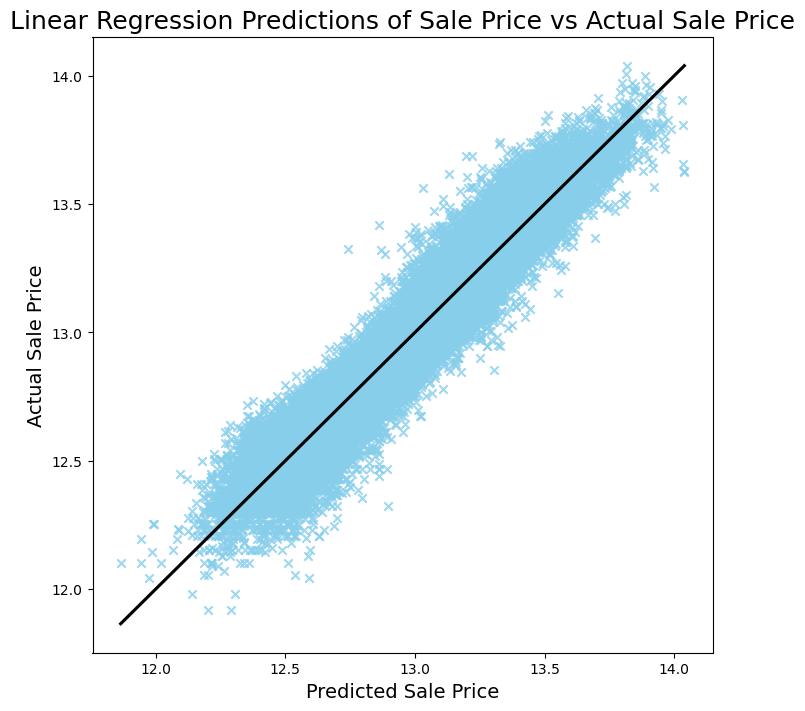

In [33]:
# Create scatterplot to show predicted values versus actual values

plt.figure(figsize=(8,8))
sns.regplot(data=X_train, x=lr_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Linear Regression Predictions of Sale Price vs Actual Sale Price', fontsize=18)

In [34]:
# Calculating the RMSE using original scale

print("Linear Regression Root Mean Squared Error:", np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lr_y_pred))))

Linear Regression Root Mean Squared Error: 44743.55397466571


The linear regression model shows clear signs of overfitting based on the large differences in individual cross-validation scores, and coefficients are highly overblown. Even though the root mean squared error is low, the model's interpretability is low and is less helpful for identifying factors that best predict housing prices.

Let's try Ridge Regression to see if regularization can help with penalising the coefficients of predictors to reduce model complexity and overfitting.

### Ridge Regression

In [35]:
# finding the optimal alpha 

# ridge_alphas = np.logspace(0, 5, 200)

# optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
# optimal_ridge.fit(X_train, y_train)

# print (optimal_ridge.alpha_)

In [36]:
# fitting to the model and getting R^2 scores

ridge = Ridge(alpha=1)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print ('Cross-Validation scores:', ridge_scores)
print ('Mean Cross-Validation score:', np.mean(ridge_scores))

Cross-Validation scores: [0.90867578 0.90990766 0.90878037 0.91011275 0.91046149 0.90909925
 0.90608849 0.90856164 0.90653219 0.91048745]
Mean Cross-Validation score: 0.9088707062517937


In [37]:
ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [38]:
print("Training score:", ridge.score(X_train, y_train))
print("Test score:", ridge.score(X_test, y_test))

Training score: 0.9090756986387871
Test score: 0.9085133965140948


In [39]:
# Predictions using Ridge
ridge_y_pred = ridge.predict(X_test)
pd.DataFrame(ridge_y_pred).head()

,0
0,13.118082
1,12.778890
2,13.525479
3,13.028341
4,13.203716


In [40]:
# MAE (the average of the absolute values of the errors) using log scale

print("Ridge Regression Mean Absolute Error:", mean_absolute_error(y_test,ridge_y_pred))

Ridge Regression Mean Absolute Error: 0.07045872305798574


In [41]:
# RMSE using log scale

print("Ridge Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,ridge_y_pred)))

Ridge Root Mean Squared Error: 0.09147340180347399


In [42]:
# Converting RMSE to original scale

print("Ridge Model Root Mean Squared Error:", np.sqrt(mean_squared_error(np.exp(y_test),np.exp(ridge_y_pred))))

Ridge Model Root Mean Squared Error: 44751.68794187046


In [43]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, ridge_y_pred))

R-Squared: 0.9085133965140948


In [44]:
# Function for getting dollar increase in resale price for 1 unit change in predictor 

def coef_fx(model):
    transformed_coef = []
    for i in model.coef_:
        j = math.exp(i)
        transformed_coef.append(j)
        coef_effect = [(i-1)*housing['resale_price'].mean() for i in transformed_coef]
    return coef_effect

In [45]:
coef_fx(ridge)[:5]

[85359.26507561478,
 -4921.569305437134,
 1981.9223413212997,
 -2139.458502858423,
 11968.778179039182]

In [46]:
# Summarising coefficients

ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_),
                            'coef_effect':coef_fx(ridge),
                           })

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)
ridge_coefs.head(50)

,variable,coef,abs_coef,coef_effect
54,flat_model_Terrace,0.590697,0.590697,361283.795472
82,planning_area_Marine Parade,0.460610,0.460610,262485.569771
73,planning_area_Changi,0.364893,0.364893,197572.755189
72,planning_area_Bukit Timah,0.364760,0.364760,197486.964791
76,planning_area_Downtown Core,0.284851,0.284851,147862.543919
93,planning_area_Tanglin,0.242260,0.242260,122989.643964
87,planning_area_Queenstown,0.189629,0.189629,93681.352600
89,planning_area_Sembawang,-0.181536,0.181536,-74483.106462
0,floor_area_sqft,0.174166,0.174166,85359.265076
68,planning_area_Bishan,0.167232,0.167232,81669.383552


In [47]:
# Comparing predictions against the test set

ridge_predicted = pd.DataFrame({'y_hat':ridge_y_pred,
                               'y_actual': y_test,
                               'residuals': (y_test - ridge_y_pred),
                               'actual test values': np.exp(y_test),
                               'predicted values': np.exp(ridge_y_pred).round(decimals = 1)                             
                              })

ridge_predicted.sort_values('residuals', inplace=True, ascending=False)
ridge_predicted.head(10)

,y_hat,y_actual,residuals,actual test values,predicted values
138112,12.741512,13.326120,0.584608,613000.0,341639.9
19592,12.861412,13.418014,0.556601,672000.0,385159.4
81810,13.028780,13.560618,0.531838,775000.0,455331.1
57950,13.195858,13.687677,0.491819,880000.0,538131.6
17649,13.130282,13.617060,0.486778,820000.0,503974.9
92310,13.218946,13.687677,0.468731,880000.0,550700.2
40999,12.870111,13.321214,0.451103,610000.0,388524.4
71279,12.885921,13.304685,0.418764,600000.0,394715.6
73389,13.107718,13.521139,0.413421,745000.0,492730.7
128994,13.327579,13.740787,0.413208,928000.0,613895.1


In [48]:
# For Kaggle

result = np.exp(y_test).to_frame('Actual Value')
result.insert(0, 'Predicted Value', np.exp(ridge_y_pred).round(-1))
result = id_no.to_frame().join(result, how='inner')
pd.DataFrame(result).reset_index(drop=True).tail()

,id,Predicted Value,Actual Value
44937,74303,437950.0,400000.0
44938,171210,537930.0,527000.0
44939,9574,330760.0,300000.0
44940,140504,410260.0,385000.0
44941,21309,336180.0,338000.0


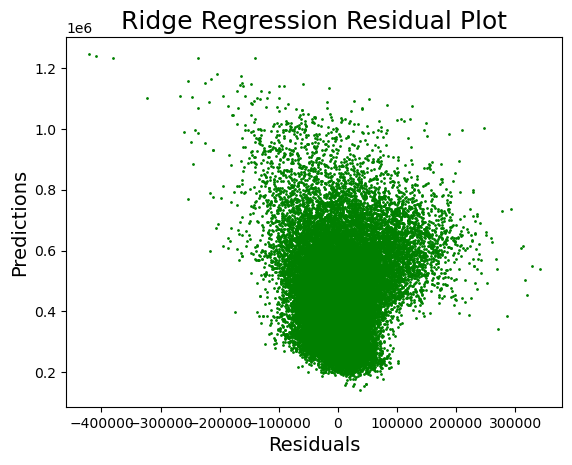

In [49]:
# Residual plot?

residuals = np.exp(y_test) - np.exp(ridge_y_pred)
plt.scatter(residuals,np.exp(ridge_y_pred), s=1, color='green')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('Ridge Regression Residual Plot', fontsize=18)
plt.show()
plt.show()

Text(0.5, 1.0, 'Ridge Regression Predictions of Sale Price vs Actual Sale Price')

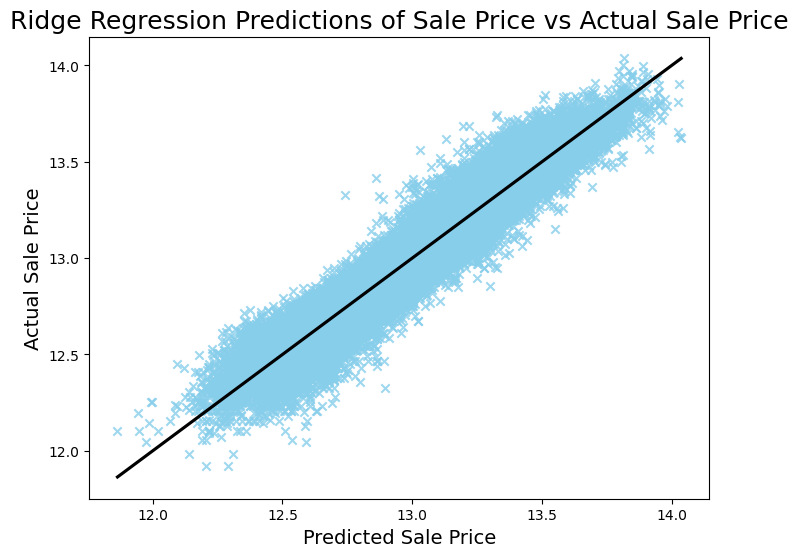

In [50]:
# Create scatterplot to show predicted values versus actual values

plt.figure(figsize=(8,6))
sns.regplot(data=X_train, x=ridge_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Ridge Regression Predictions of Sale Price vs Actual Sale Price', fontsize=18)

Text(0.5, 1.0, 'Ridge Regression Predictions of Sale Price vs Actual Sale Price')

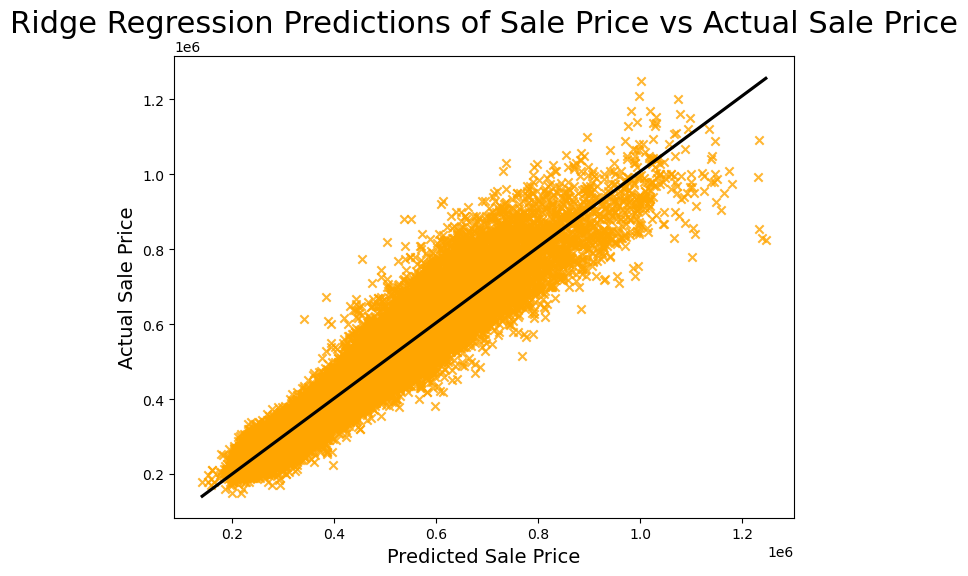

In [51]:
# Create scatterplot to show predicted values versus actual values (not logged)

plt.figure(figsize=(8,6))
sns.regplot(data=X_train, x=np.exp(ridge_y_pred), y=np.exp(y_test), 
            marker='x', color='orange', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Ridge Regression Predictions of Sale Price vs Actual Sale Price', fontsize=22)

This time the model doesn't overfit, and the RMSE remains low. But perhaps more can done to improve the accuracy of the model and removing variables that do not explain much of the variance in resale price. We try L1 regularisation to see if a Lasso regression could perform automated feature selection and pick variables that are best at predicting resale prices. 

### Lasso Regression

In [52]:
# Using LassoCV to obtain the optimal alpha

optimal_lasso = LassoCV(n_alphas=1000, cv=10)
optimal_lasso.fit(X_train, y_train)

print (optimal_lasso.alpha_)

0.00035600394300396926


In [53]:
# Running cross-validation

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print ('Cross-Validation scores:', lasso_scores)
print ('Cross-Validation mean score:', np.mean(lasso_scores))

Cross-Validation scores: [0.90091906 0.90278989 0.9014351  0.90256241 0.90284751 0.90265958
 0.89986068 0.89926893 0.89831979 0.90263862]
Cross-Validation mean score: 0.9013301563333993


Minimal overfitting 

In [54]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.00035600394300396926)

In [55]:
print("Training set score:", lasso.score(X_train, y_train))
print("Test set score:", lasso.score(X_test, y_test))

Training set score: 0.9014682532102657
Test set score: 0.9004557201711496


In [56]:
# Obtaining each predictor's coefficient and converting it to show the effect of every unit change

lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_),
                            'coef_effect':coef_fx(lasso),
                           })

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(30)

,variable,coef,abs_coef,coef_effect
82,planning_area_Marine Parade,0.368578,0.368578,199958.765030
0,floor_area_sqft,0.221594,0.221594,111297.332714
72,planning_area_Bukit Timah,0.189317,0.189317,93511.877420
96,planning_area_Woodlands,-0.171323,0.171323,-70642.058323
89,planning_area_Sembawang,-0.166867,0.166867,-68953.712928
87,planning_area_Queenstown,0.143730,0.143730,69350.932882
40,flat_model_DBSS,0.142522,0.142522,68725.378735
74,planning_area_Choa Chu Kang,-0.130516,0.130516,-54897.140062
68,planning_area_Bishan,0.121801,0.121801,58114.634991
75,planning_area_Clementi,0.112273,0.112273,53309.172863


In [57]:
# Predictors that were removed

lasso_coefs[lasso_coefs['abs_coef'] == 0]

,variable,coef,abs_coef,coef_effect
6,hawker_market_stalls,0.0,0.0,0.0
73,planning_area_Changi,0.0,0.0,0.0
84,planning_area_Outram,0.0,0.0,0.0
86,planning_area_Punggol,-0.0,0.0,0.0
88,planning_area_Rochor,-0.0,0.0,0.0
83,planning_area_Novena,-0.0,0.0,0.0
76,planning_area_Downtown Core,0.0,0.0,0.0
93,planning_area_Tanglin,0.0,0.0,0.0
94,planning_area_Toa Payoh,-0.0,0.0,0.0
95,planning_area_Western Water Catchment,-0.0,0.0,0.0


In [58]:
lasso_y_pred = lasso.predict(X_test)
lasso_y_pred

array([12.96405364, 12.77704703, 13.51902975, ..., 13.34328182,
       12.64915433, 12.8952522 ])

In [59]:
# MAE using log scale

print("Lasso Regression Mean Absolute Error:", mean_absolute_error(y_test,lasso_y_pred))

Lasso Regression Mean Absolute Error: 0.07284159124634734


In [60]:
# Calculating the RMSE using log scale

print("Lasso Root Mean Squared Error (log scale):", np.sqrt(mean_squared_error(y_test,lasso_y_pred)))

Lasso Root Mean Squared Error (log scale): 0.0954166649159687


In [61]:
# Calculating the RMSE using original scale

print("Lasso Root Mean Squared Error:", np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lasso_y_pred))))

Lasso Root Mean Squared Error: 46688.510263211596


In [62]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, lasso_y_pred))

R-Squared: 0.9004557201711496


In [63]:
# Comparing predictions against the test set

lasso_predicted = pd.DataFrame({'y_hat':lasso.predict(X_test),
                               'y_actual': y_test,
                               'residuals': (y_test - lasso.predict(X_test)),
                               'actual test values': np.exp(y_test),
                               'predicted values': np.exp(lasso_y_pred).round(decimals = 1)                             
                              })

lasso_predicted.sort_values('residuals', inplace=True, ascending=False)
lasso_predicted

,y_hat,y_actual,residuals,actual test values,predicted values
89536,12.694343,13.527828,0.833486,750000.0,325899.0
106004,12.780545,13.607256,0.826710,812000.0,355238.7
43566,12.679087,13.500800,0.821712,730000.0,320965.0
31931,12.720413,13.487006,0.766593,720000.0,334507.0
112473,12.721506,13.487006,0.765500,720000.0,334872.8
...,...,...,...,...,...
131121,12.611018,12.154779,-0.456239,190000.0,299844.2
130263,12.604325,12.128111,-0.476214,185000.0,297843.9
30303,12.542012,12.055250,-0.486762,172000.0,279850.7
84773,12.865728,12.323856,-0.541873,225000.0,386825.2


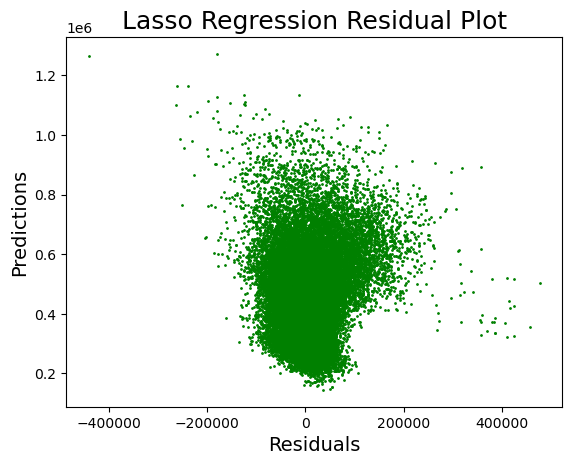

In [64]:
# Residual plot?

residuals = np.exp(y_test) - np.exp(lasso_y_pred)
plt.scatter(residuals,np.exp(lasso_y_pred), s=1, color='green')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('Lasso Regression Residual Plot', fontsize=18)
plt.show()

Text(0.5, 1.0, 'Lasso Predictions of Sale Price vs Actual Sale Price')

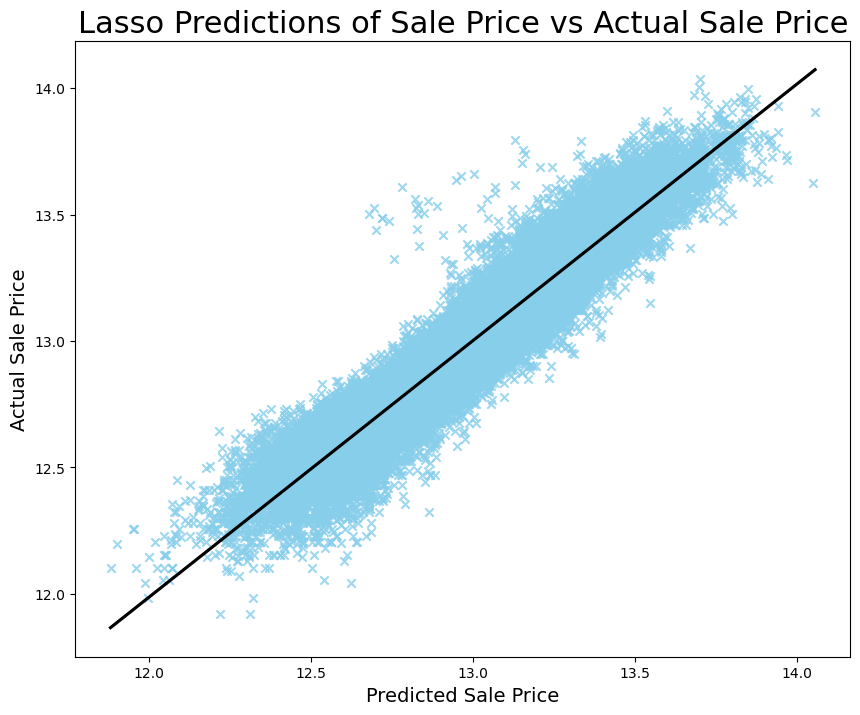

In [65]:
# Create scatterplot to show predicted values versus actual values


plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=lasso_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=22)

Text(0.5, 1.0, 'Lasso Regression Predictions of Sale Price vs Actual Sale Price')

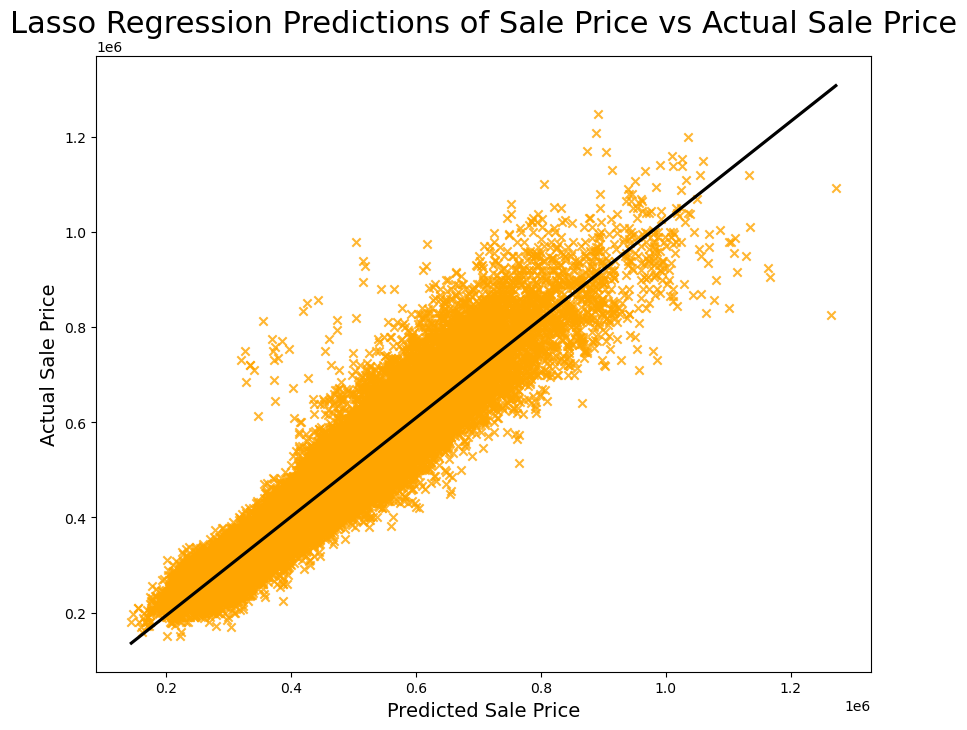

In [66]:
# Create scatterplot to show predicted values versus actual values (tranforming back from log)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=np.exp(lasso_y_pred), y=np.exp(y_test), 
            marker='x', color='orange', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Regression Predictions of Sale Price vs Actual Sale Price', fontsize=22)

RMSE of the Lasso Regression is higher than the Ridge Regression 0.081 vs 0.080. 

### ElasticNet

In [67]:
# Finding the optimal alpha and l1 ratio

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=1000, cv=10)
optimal_enet.fit(X_train, y_train)

print (f'Optimal alpha: {optimal_enet.alpha_}')
print (f'Optimal L1 ratio: {optimal_enet.l1_ratio_}')


Optimal alpha: 0.00035600394300396926
Optimal L1 ratio: 1.0


In [68]:
# fitting the model

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

print ("Cross-Validation scores: ", enet_scores)
print ("Cross-Validation mean score: ", np.mean(enet_scores))

Cross-Validation scores:  [0.90091906 0.90278989 0.9014351  0.90256241 0.90284751 0.90265958
 0.89986068 0.89926893 0.89831979 0.90263862]
Cross-Validation mean score:  0.9013301563333993


In [69]:
enet.fit(X_train, y_train)

ElasticNet(alpha=0.00035600394300396926, l1_ratio=1.0)

In [70]:
print("Training set scores: ", enet.score(X_train, y_train))
print("Test set scores: ", enet.score(X_test, y_test))

Training set scores:  0.9014682532102657
Test set scores:  0.9004557201711496


In [71]:
enet_y_pred = enet.predict(X_test)

In [72]:
# MAE using log scale

print("ElasticNet Regression Mean Absolute Error:", mean_absolute_error(y_test,enet_y_pred))

ElasticNet Regression Mean Absolute Error: 0.07284159124634734


In [73]:
print("ElasticNet Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,enet_y_pred)))

ElasticNet Root Mean Squared Error: 0.0954166649159687


In [74]:
# Calculating the RMSE using original scale

print("ElasticNet Root Mean Squared Error:", np.sqrt(mean_squared_error(np.exp(y_test),np.exp(enet_y_pred))))

ElasticNet Root Mean Squared Error: 46688.510263211596


In [75]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, enet_y_pred))

R-Squared: 0.9004557201711496


In [76]:
# Predicting on the test set

enet_predicted = pd.DataFrame({'y_hat':enet.predict(X_test),
                               'y_actual': y_test,
                               'residuals': (y_test - enet.predict(X_test)),
                               'actual test values': np.exp(y_test),
                               'predicted values': np.exp(enet_y_pred).round(decimals = 1)                             
                              })

enet_predicted.sort_values('residuals', inplace=True, ascending=False)
enet_predicted.head(10)

,y_hat,y_actual,residuals,actual test values,predicted values
89536,12.694343,13.527828,0.833486,750000.0,325899.0
106004,12.780545,13.607256,0.826710,812000.0,355238.7
43566,12.679087,13.500800,0.821712,730000.0,320965.0
31931,12.720413,13.487006,0.766593,720000.0,334507.0
112473,12.721506,13.487006,0.765500,720000.0,334872.8
11946,12.821981,13.560618,0.738637,775000.0,370267.6
116157,12.700251,13.437174,0.736923,685000.0,327830.2
46572,12.741522,13.473020,0.731498,710000.0,341643.2
106220,12.832668,13.538439,0.705771,758000.0,374245.6
49435,12.824105,13.527828,0.703723,750000.0,371054.8


In [77]:
# Coefficients of predictors

enet_coefs = pd.DataFrame({'variable':X.columns,
                           'enet_coef':enet.coef_,
                           'enet_abs_coef':np.abs(enet.coef_),
                           'coef_effect':coef_fx(enet)})

enet_coefs.sort_values('enet_abs_coef', inplace=True, ascending=False)
enet_coefs.head(30)

,variable,enet_coef,enet_abs_coef,coef_effect
82,planning_area_Marine Parade,0.368578,0.368578,199958.765030
0,floor_area_sqft,0.221594,0.221594,111297.332714
72,planning_area_Bukit Timah,0.189317,0.189317,93511.877420
96,planning_area_Woodlands,-0.171323,0.171323,-70642.058323
89,planning_area_Sembawang,-0.166867,0.166867,-68953.712928
87,planning_area_Queenstown,0.143730,0.143730,69350.932882
40,flat_model_DBSS,0.142522,0.142522,68725.378735
74,planning_area_Choa Chu Kang,-0.130516,0.130516,-54897.140062
68,planning_area_Bishan,0.121801,0.121801,58114.634991
75,planning_area_Clementi,0.112273,0.112273,53309.172863


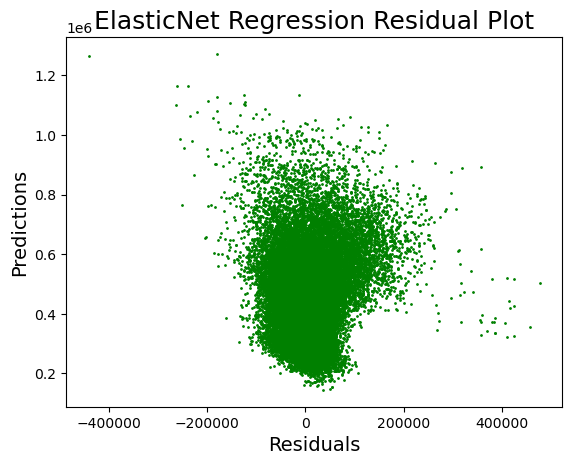

In [78]:
# Residual plot?

residuals = np.exp(y_test) - np.exp(enet_y_pred)
plt.scatter(residuals,np.exp(enet_y_pred), s=1, color='green')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.title('ElasticNet Regression Residual Plot', fontsize=18)
plt.show()

Text(0.5, 1.0, 'ElasticNet Predictions of Sale Price vs Actual Sale Price')

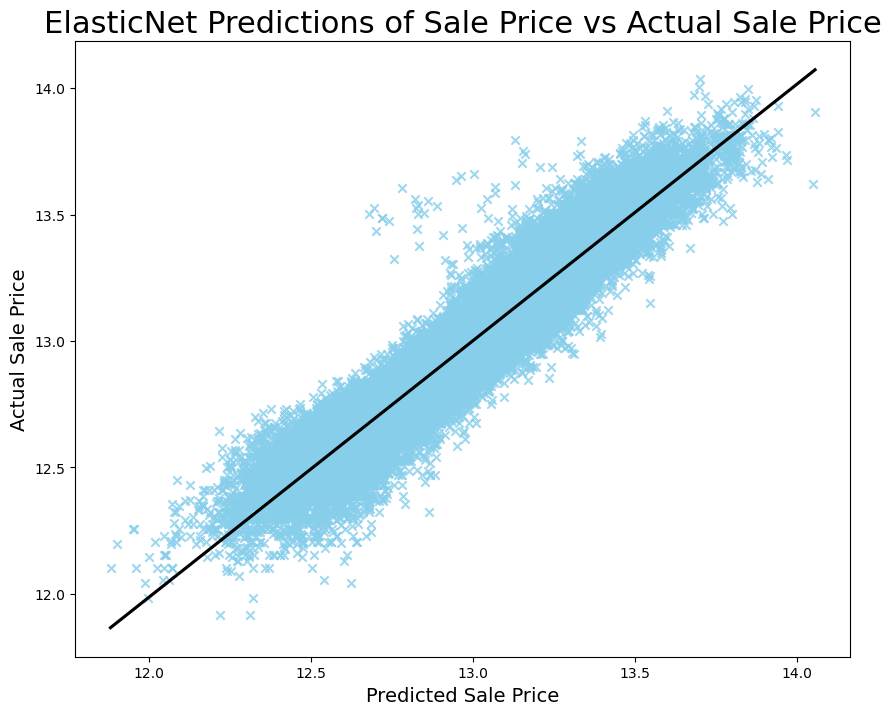

In [79]:
# Create scatterplot to show predicted values versus actual values (logged)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=enet_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('ElasticNet Predictions of Sale Price vs Actual Sale Price', fontsize=22)

Text(0.5, 1.0, 'ElasticNet Regression Predictions of Sale Price vs Actual Sale Price')

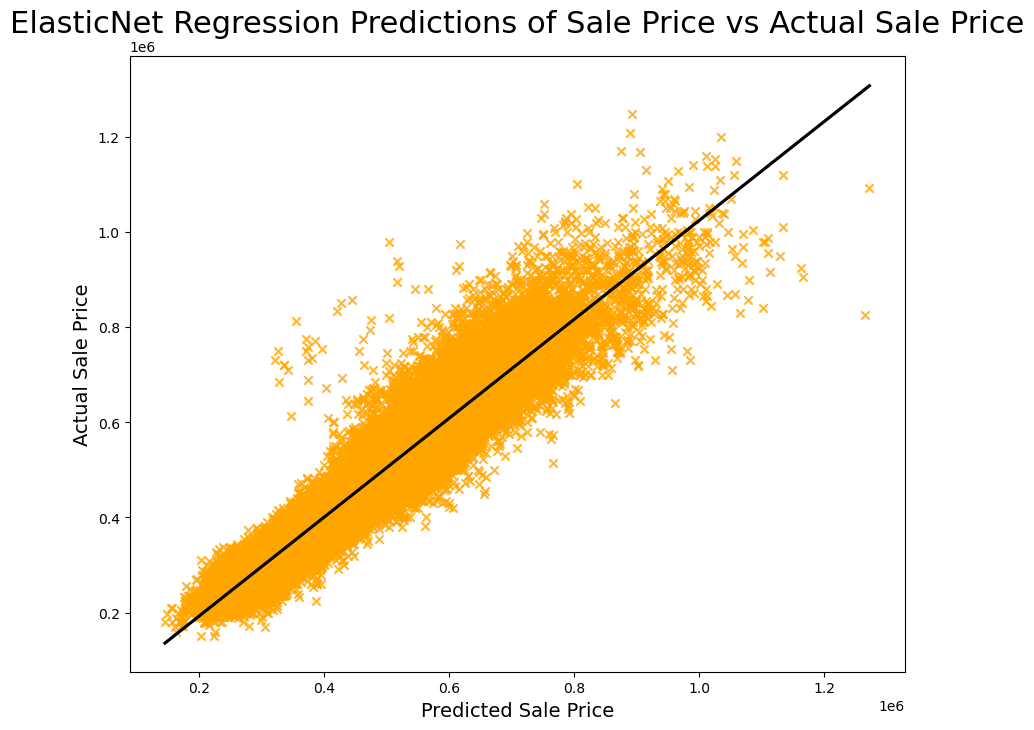

In [80]:
# Create scatterplot to show predicted values versus actual values (not logged)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=np.exp(enet_y_pred), y=np.exp(y_test), 
            marker='x', color='orange', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('ElasticNet Regression Predictions of Sale Price vs Actual Sale Price', fontsize=22)

---

### Review

**Comparison between the 3 Models**:


|   	| Presence of overfitting  	| Root Mean Squared Error  	|  R-Squared Scores 	|  Remarks 	|
|---	|---	|---	|---	|---	|
| Linear Regression  	|  Yes 	|  40410 	|  0.93 	|  Severe overfitting, inflated coefficients, most of which had p-values > 0.05  	|
|  Ridge Regression 	| No  	| 40392  	|  0.93 	| Slight improvement over linear regression with a lower RMSE  	|
|  Lasso Regression 	|   No	| 45832  	|  0.90 	|  Performs worse than Ridge regression, despite automated feature selection 	|
|  ElasticNet Regression 	| No  	|   43730	|  0.88 	|   	|


- While the linear regression model outperformed the baseline mean score with an RMSE of 40410 vs 143239, the model produced considerable overfitting and overblown coefficients. Most of the features had p-values above 0.05, implying that the feature had little effect on resale price.
- Ridge, Lasso and ElasticNet regression outperformed linear regression with the help of regularization of the large number of features, with smaller RMSE and MAE scores. 


**Conclusion and Recommendations**

The top predictive features for our model seem pretty plausible. Our top features are living area and overall quality, followed by a range of features looking at basement square footage and the quality of the exterior and kitchen. Home functionality and the number of cars that a garage can fit are also important in predicting sale price. Certain neighborhoods like Northridge Heights and Stone Brook also are strong positive predictors.

Conversely, we see that houses that are in MS SubClass_120 (1 story houses built in 1946 and after, as part of a planned unit development) predict lower prices. The Old Town neighborhood also predicts lower prices, along with certain features such as the number of kitchens or bedrooms above ground. Having two stories also hurts the value of the home.

Future Steps
- TBC



-----

## Production Model

## 1. Cleaning and Feature Engineering

In [81]:
# Set max views for columns and rows for ease of EDA

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.set_option('mode.chained_assignment', None)

In [82]:
test_df = pd.read_csv('./datasets/test.csv', low_memory=False)
test_df.shape

(16737, 77)

In [83]:
#saving original test set 

test_df1 = test_df

In [84]:
test_df.drop('price_per_sqft', inplace = True, axis = 1)

In [85]:
test_df.isnull().sum()

id                               0
Tranc_YearMonth                  0
town                             0
flat_type                        0
block                            0
street_name                      0
storey_range                     0
floor_area_sqm                   0
flat_model                       0
lease_commence_date              0
Tranc_Year                       0
Tranc_Month                      0
mid_storey                       0
lower                            0
upper                            0
mid                              0
full_flat_type                   0
address                          0
floor_area_sqft                  0
hdb_age                          0
max_floor_lvl                    0
year_completed                   0
residential                      0
commercial                       0
market_hawker                    0
multistorey_carpark              0
precinct_pavilion                0
total_dwelling_units             0
1room_sold          

In [86]:
# Dropping rows in Mall Nearest Distance based on reasons listed in EDA and cleaning 

no_mall_distance = test_df[(test_df['Mall_Nearest_Distance'].isnull()) & 
                           (test_df['Mall_Within_500m'].isnull())]
to_drop = no_mall_distance.index
test_df.drop(to_drop, inplace = True)

In [87]:
# Applying on the required columns

cols = ['Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 
        'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km']

result = [test_df[col].fillna(0, inplace = True) for col in cols]

In [88]:
# Taking Tanjong Pagar as proxy for CBD

test_df['CBD_latitude'] = [1.275619 for x in test_df['Latitude']]
test_df['CBD_longitude'] = [103.842431 for x in test_df['Longitude']]

In [89]:
# Formula for straight line distance based on latitude and longitude

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [90]:
# Creating a new column for distance from CBD

test_df['distance_from_CBD'] = haversine_np(test_df['Latitude'],test_df['Longitude'],test_df['CBD_latitude'],test_df['CBD_longitude'])

In [91]:
test_df['1_2_3_rooms_sold'] = test_df['1room_sold'] + test_df['2room_sold'] + test_df['3room_sold']
test_df['4_5_other_rooms_sold'] = test_df['4room_sold'] + test_df['5room_sold'] + test_df['exec_sold'] + test_df['multigen_sold'] + test_df['studio_apartment_sold']

In [92]:
# replace all storey-related variables with mid-storey as the estimated median height  

test_df['est_floor_level'] = test_df['mid_storey']  

In [93]:
# Creating a new variable to estimate the unit's age at the point of transaction 

test_df['age_at_sale'] = test_df['Tranc_Year'] - test_df['lease_commence_date']

In [94]:
# Dropping all variables for reasons mentioned under EDA and cleaning 

test_df.drop(columns = ['Latitude', 'Longitude','mrt_latitude', 'mrt_longitude',
                        'bus_stop_latitude','bus_stop_longitude','pri_sch_latitude',
                        'pri_sch_longitude','sec_sch_longitude','sec_sch_latitude','postal',
                        'CBD_latitude','CBD_longitude','Mall_Within_500m', 'Hawker_Within_500m', 
                        'Mall_Within_1km', 'Hawker_Within_1km','mrt_interchange',
                        'affiliation', 'pri_sch_affiliation', '1room_rental','2room_rental', 
                        'floor_area_sqm','3room_rental', 'other_room_rental', '1room_sold', 
                        '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 
                        'multigen_sold','studio_apartment_sold','total_dwelling_units', 
                        'storey_range', 'lower','upper', 'mid','mid_storey','max_floor_lvl',
                        'bus_interchange','hdb_age','year_completed','Tranc_YearMonth',
                        'lease_commence_date', 'residential','market_hawker','multistorey_carpark',
                        'full_flat_type', 'Tranc_Month','precinct_pavilion','cutoff_point', 
                        'vacancy', 'town', 'street_name', 'block', 'address', 
                        'mrt_name','bus_stop_name', 'pri_sch_name','sec_sch_name'],
             inplace = True)

In [95]:
# To log all variables with large scales, but first replace 0 with 0.01 since log(0) is undefined. 

cols2 = ['Mall_Nearest_Distance', 'Mall_Within_2km', 'Hawker_Within_2km', 
         'hawker_food_stalls', 'hawker_market_stalls', '1_2_3_rooms_sold', '4_5_other_rooms_sold']

result = [test_df[col].replace({0:1}, inplace = True) for col in cols2]


In [96]:
# Converting the following variables to categorical 

test_df['Tranc_Year'] = test_df['Tranc_Year'].astype('object')

In [97]:
test_df_num = test_df.select_dtypes("number")
test_df_num.drop('id', axis = 1, inplace = True)
test_df_num.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale
0,904.176,877.431572,4.0,687.576779,1.0,56,123,686.660434,75.683952,426.467910,156.322353,4.470969,1,132,8,25
1,1205.568,534.037705,3.0,2122.346226,1.0,72,94,169.478175,88.993058,439.756851,739.371688,16.389521,1,53,5,11
2,731.952,817.050453,3.0,152.287621,11.0,50,100,694.220448,86.303575,355.882207,305.071191,2.925177,191,24,8,33
3,1044.108,1272.737194,3.0,501.892158,2.0,52,112,1117.203587,108.459039,929.744711,433.454591,8.905655,1,104,2,38
4,1108.692,1070.963675,5.0,437.593564,2.0,60,87,987.976010,113.645431,309.926934,217.295361,11.525598,1,144,17,31


In [98]:
# Log transforming numerical variables

test_df[test_df_num.columns] = np.log(test_df_num)

In [99]:
test_df.head()

,id,flat_type,flat_model,Tranc_Year,floor_area_sqft,commercial,planning_area,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale
0,114982,4 ROOM,Simplified,2012,6.807024,Y,Yishun,6.776999,1.386294,6.533174,0.000000,4.025352,4.812184,6.531840,4.326566,6.055537,5.051920,1.497605,0.000000,4.882802,2.079442,3.218876
1,95653,5 ROOM,Premium Apartment,2019,7.094706,N,Jurong West,6.280466,1.098612,7.660277,0.000000,4.276666,4.543295,5.132724,4.488558,6.086222,6.605801,2.796642,0.000000,3.970292,1.609438,2.397895
2,40303,3 ROOM,New Generation,2013,6.595715,N,Ang Mo Kio,6.705701,1.098612,5.025771,2.397895,3.912023,4.605170,6.542790,4.457871,5.874600,5.720545,1.073355,5.252273,3.178054,2.079442,3.496508
3,109506,4 ROOM,New Generation,2017,6.950918,N,Woodlands,7.148925,1.098612,6.218385,0.693147,3.951244,4.718499,7.018584,4.686373,6.834910,6.071787,2.186687,0.000000,4.644391,0.693147,3.637586
4,100149,4 ROOM,Model A,2016,7.010936,N,Bukit Batok,6.976314,1.609438,6.081291,0.693147,4.094345,4.465908,6.895658,4.733083,5.736337,5.381258,2.444571,0.000000,4.969813,2.833213,3.433987


In [100]:
test_df.shape

(16653, 22)

In [101]:
# extracting id column

id_no = test_df['id']
test_df2 = test_df.drop('id', axis = 1)

In [102]:
# Standardising predictors

ss = StandardScaler()
num_ss = ss.fit_transform(test_df_num)
num_ss = pd.DataFrame(num_ss, columns = test_df_num.columns)

In [103]:
num_ss.shape

(16653, 16)

In [104]:
num_ss.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale
0,-0.528821,0.587939,-0.347956,-0.445053,-0.781807,0.392936,1.183594,-0.184277,-0.700464,0.133967,-1.132811,-0.782850,-0.582699,0.952734,-0.047075,0.065695
1,0.615086,-0.347053,-0.638889,0.889958,-0.781807,1.239082,0.653114,-1.385057,-0.461579,0.190696,0.732007,2.289649,-0.582699,-0.571064,-0.594905,-1.111843
2,-1.182482,0.423533,-0.638889,-0.943124,1.792372,0.075631,0.762868,-0.166724,-0.509852,-0.167355,-0.657055,-1.181341,2.114155,-1.130432,-0.047075,0.738573
3,0.002279,1.664276,-0.638889,-0.617827,-0.524389,0.181400,0.982377,0.815347,-0.112183,2.282396,-0.246435,0.360374,-0.582699,0.412654,-1.142735,1.159123
4,0.247402,1.114888,-0.057023,-0.677655,-0.524389,0.604472,0.525067,0.515310,-0.019092,-0.363533,-0.937796,1.035772,-0.582699,1.184197,1.596414,0.570354


In [105]:
# Identifying categorical predictors for one-hot encoding

categorical_var = test_df2.select_dtypes(include=['object'])
categorical_var

,flat_type,flat_model,Tranc_Year,commercial,planning_area
0,4 ROOM,Simplified,2012,Y,Yishun
1,5 ROOM,Premium Apartment,2019,N,Jurong West
2,3 ROOM,New Generation,2013,N,Ang Mo Kio
3,4 ROOM,New Generation,2017,N,Woodlands
4,4 ROOM,Model A,2016,N,Bukit Batok
...,...,...,...,...,...
16732,3 ROOM,New Generation,2016,N,Ang Mo Kio
16733,4 ROOM,Premium Apartment,2017,N,Punggol
16734,5 ROOM,Improved,2018,N,Choa Chu Kang
16735,4 ROOM,Simplified,2020,N,Bishan


In [106]:
categorical_var.shape

(16653, 5)

In [107]:
# Dummifying all categorical variables

categorical_var = pd.get_dummies(columns=categorical_var.columns, data=test_df2, drop_first=True)

/var/folders/r9/9246nqp9249ghjl6r9xy_dwr0000gn/T/ipykernel_7451/3112809898.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical_var = pd.get_dummies(columns=categorical_var.columns, data=test_df2, drop_first=True)


In [108]:
categorical_var.shape

(16653, 81)

In [109]:
categorical_var.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,6.807024,6.776999,1.386294,6.533174,0.000000,4.025352,4.812184,6.531840,4.326566,6.055537,5.051920,1.497605,0.000000,4.882802,2.079442,3.218876,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,7.094706,6.280466,1.098612,7.660277,0.000000,4.276666,4.543295,5.132724,4.488558,6.086222,6.605801,2.796642,0.000000,3.970292,1.609438,2.397895,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.595715,6.705701,1.098612,5.025771,2.397895,3.912023,4.605170,6.542790,4.457871,5.874600,5.720545,1.073355,5.252273,3.178054,2.079442,3.496508,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.950918,7.148925,1.098612,6.218385,0.693147,3.951244,4.718499,7.018584,4.686373,6.834910,6.071787,2.186687,0.000000,4.644391,0.693147,3.637586,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,7.010936,6.976314,1.609438,6.081291,0.693147,4.094345,4.465908,6.895658,4.733083,5.736337,5.381258,2.444571,0.000000,4.969813,2.833213,3.433987,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
test_df3 = pd.concat([num_ss.reset_index() , categorical_var.reset_index() ], axis=1)

In [111]:
test_df3.drop(columns = 'index', inplace = True)

In [112]:
# final dataset for production model

test_df3.shape

(16653, 97)

In [113]:
test_df3.head()

,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,floor_area_sqft,Mall_Nearest_Distance,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,distance_from_CBD,1_2_3_rooms_sold,4_5_other_rooms_sold,est_floor_level,age_at_sale,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,Tranc_Year_2013,Tranc_Year_2014,Tranc_Year_2015,Tranc_Year_2016,Tranc_Year_2017,Tranc_Year_2018,Tranc_Year_2019,Tranc_Year_2020,Tranc_Year_2021,commercial_Y,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,planning_area_Bukit Merah,planning_area_Bukit Panjang,planning_area_Bukit Timah,planning_area_Changi,planning_area_Choa Chu Kang,planning_area_Clementi,planning_area_Downtown Core,planning_area_Geylang,planning_area_Hougang,planning_area_Jurong East,planning_area_Jurong West,planning_area_Kallang,planning_area_Marine Parade,planning_area_Novena,planning_area_Outram,planning_area_Pasir Ris,planning_area_Punggol,planning_area_Queenstown,planning_area_Rochor,planning_area_Sembawang,planning_area_Sengkang,planning_area_Serangoon,planning_area_Tampines,planning_area_Tanglin,planning_area_Toa Payoh,planning_area_Western Water Catchment,planning_area_Woodlands,planning_area_Yishun
0,-0.528821,0.587939,-0.347956,-0.445053,-0.781807,0.392936,1.183594,-0.184277,-0.700464,0.133967,-1.132811,-0.782850,-0.582699,0.952734,-0.047075,0.065695,6.807024,6.776999,1.386294,6.533174,0.000000,4.025352,4.812184,6.531840,4.326566,6.055537,5.051920,1.497605,0.000000,4.882802,2.079442,3.218876,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.615086,-0.347053,-0.638889,0.889958,-0.781807,1.239082,0.653114,-1.385057,-0.461579,0.190696,0.732007,2.289649,-0.582699,-0.571064,-0.594905,-1.111843,7.094706,6.280466,1.098612,7.660277,0.000000,4.276666,4.543295,5.132724,4.488558,6.086222,6.605801,2.796642,0.000000,3.970292,1.609438,2.397895,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.182482,0.423533,-0.638889,-0.943124,1.792372,0.075631,0.762868,-0.166724,-0.509852,-0.167355,-0.657055,-1.181341,2.114155,-1.130432,-0.047075,0.738573,6.595715,6.705701,1.098612,5.025771,2.397895,3.912023,4.605170,6.542790,4.457871,5.874600,5.720545,1.073355,5.252273,3.178054,2.079442,3.496508,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.002279,1.664276,-0.638889,-0.617827,-0.524389,0.181400,0.982377,0.815347,-0.112183,2.282396,-0.246435,0.360374,-0.582699,0.412654,-1.142735,1.159123,6.950918,7.148925,1.098612,6.218385,0.693147,3.951244,4.718499,7.018584,4.686373,6.834910,6.071787,2.186687,0.000000,4.644391,0.693147,3.637586,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.247402,1.114888,-0.057023,-0.677655,-0.524389,0.604472,0.525067,0.515310,-0.019092,-0.363533,-0.937796,1.035772,-0.582699,1.184197,1.596414,0.570354,7.010936,6.976314,1.609438,6.081291,0.693147,4.094345,4.4

## Predicting on Production Model

In [114]:
# Refit model on entire training dataset, and dropping columns that do not appear in the test dataset

ridge = RidgeCV()
X.drop(columns = ["pri_sch_name_Saint Gabriel's Primary School", "flat_model_Adjoined flat"], inplace = True)
ridge.fit(X, y)
ridge.score(X, y)

KeyError: '["pri_sch_name_Saint Gabriel\'s Primary School" \'flat_model_Adjoined flat\'] not found in axis'

In [ ]:
# Predicting using ridge

y_pred_pdtn = ridge.predict(test_df3)
y_pred_pdtn

In [ ]:
# Obtaining list of predicted values

ridge_predicted = pd.DataFrame({'id': id_no,
                                'raw_predictions':y_pred_pdtn,
                                'predicted_resale_price': np.exp(y_pred_pdtn).round(decimals = 1)
                               })

ridge_predicted

In [ ]:
# Function for getting dollar increase in resale price for 1 unit change in predictor 

def coef_fx(model):
    transformed_coef = []
    for i in model.coef_:
        j = math.exp(i)
        transformed_coef.append(j)
        coef_effect = [(i-1)*housing['resale_price'].mean() for i in transformed_coef]
    return coef_effect

In [ ]:
# Summarising coefficients

ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_),
                            'coef_effect':coef_fx(ridge),
                           })

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)
ridge_coefs.head(50)

In [ ]:
full_dataset = ridge_predicted.merge(test_df, on = 'id', how = 'left')
full_dataset.head()

In [ ]:
full_dataset.groupby('planning_area')['predicted_resale_price'].median().sort_values(ascending = False)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(y="flat_model", x="predicted_resale_price",
            palette=["b"],
            data=full_dataset)

sns.despine(offset=10, trim=True)


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(y="planning_area", x="predicted_resale_price",
            palette=["b"],
            data=full_dataset)

sns.despine(offset=10, trim=True)
